# DSM150 - Neural Networks Coursework 2

In the following coursework a Convolutional Neural Network is created in order to solve a multi-class classification problem. The report follows the apporach follows the book deeplearning with python. 

## Approach

1. Load Data
2. Explorative Data Analysis
3. Prepare Data
4. Create Baseline Model
5. Finetune Model
6. Conclusion

# 1. Load the Data

The used dateset was downloaded from Kaggel.

In [1]:
# import external libs
import  os
import tensorflow as tf

In [2]:
# define base directory where pictures stored
data_dir= './data/animals'

# Explorative Data Analysis

In [3]:
train_pictures= []
val_pictures= []
data= []

train_dir= os.path.join(data_dir, 'train')
val_dir= os.path.join(data_dir, 'val')

print('Files in training directory:')
for directory in os.listdir(train_dir):
            counter= 0
            for file in os.listdir(os.path.join(train_dir, directory)):
                counter+=1
            print(f'\t{directory}: {counter} pictures')
            data.append(('test', str(directory), counter))
            
            
print('\nFiles in validation directory:')
for directory in os.listdir(val_dir):
            counter= 0
            for file in os.listdir(os.path.join(val_dir, directory)):
                counter+=1
            print(f'\t{directory}: {counter} pictures')
            data.append(('test', str(directory), counter))

Files in training directory:
	cat: 2737 pictures
	dog: 2627 pictures
	horse: 2705 pictures
	lion: 2675 pictures
	elephant: 2730 pictures

Files in validation directory:
	cat: 300 pictures
	dog: 300 pictures
	horse: 300 pictures
	lion: 298 pictures
	elephant: 299 pictures


The classes and corresponding picture seems to be balanced. Each of the five classes is represented within between 2'675 to 2'737 pictures.

# Image Preprocessing

In [4]:
# import lib for Image Generator
from keras.preprocessing.image import ImageDataGenerator

# rescale images by 1/255
train_datagen= ImageDataGenerator(rescale=1./255)
val_datagen= ImageDataGenerator(rescale=1./255)

# read img from target dirs, resize image to 150x150, 
train_generator= train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    shuffle= True
    
)


Found 13474 images belonging to 5 classes.


In [5]:
val_generator= val_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 1497 images belonging to 5 classes.


In [6]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Data batch shape: (32, 150, 150, 3)
Labels batch shape: (32, 5)


In [7]:
def generate_file_path_labels(base_dir):
    categories= ['train', 'val']
    train_file_paths_labels= []
    val_file_paths_labels= []

    for category in categories:

        # define path to the basedir
        base_dir= os.path.join(data_dir, category)

        for animal_name in os.listdir(base_dir):
            animal_dir=  os.path.join(base_dir, animal_name)
            if os.path.isdir(animal_dir):
                for file_name in os.listdir(animal_dir):
                    file_path= os.path.join(animal_dir, file_name)

                    if category == 'train':
                        train_file_paths_labels.append((animal_name, file_path))
                    if category == 'val':
                        val_file_paths_labels.append((animal_name, file_path))



    return train_file_paths_labels, val_file_paths_labels

In [8]:
data_dir= './data/animals'
train_file_paths_labels, val_file_paths_labels= generate_file_path_labels(data_dir)

In [9]:
print(train_file_paths_labels[:10])
print(val_file_paths_labels[:10])

[('cat', './data/animals/train/cat/cat1594.jpg'), ('cat', './data/animals/train/cat/cat108.jpg'), ('cat', './data/animals/train/cat/cat2089.jpg'), ('cat', './data/animals/train/cat/cat1580.jpg'), ('cat', './data/animals/train/cat/cat652.jpg'), ('cat', './data/animals/train/cat/cat134.jpg'), ('cat', './data/animals/train/cat/cat120.jpg'), ('cat', './data/animals/train/cat/cat646.jpg'), ('cat', './data/animals/train/cat/cat875.jpg'), ('cat', './data/animals/train/cat/cat1557.jpg')]
[('cat', './data/animals/val/cat/cat108.jpg'), ('cat', './data/animals/val/cat/cat134.jpg'), ('cat', './data/animals/val/cat/cat120.jpg'), ('cat', './data/animals/val/cat/cat60.jpg'), ('cat', './data/animals/val/cat/cat74.jpg'), ('cat', './data/animals/val/cat/cat48.jpg'), ('cat', './data/animals/val/cat/cat242.jpg'), ('cat', './data/animals/val/cat/cat256.jpg'), ('cat', './data/animals/val/cat/cat281.jpg'), ('cat', './data/animals/val/cat/cat295.jpg')]


The directory containing the dataset consists of three folders: 'inf' , 'train' and 'test'. Obviously the two of three folders holding trainings and test data. The test and trainings folder hold additional 5 subdirectory divided into animals name. The dir 'inf' holding 5 pictures on the next child level providing some informative representations of the animals used in this dataset.

# 2. Create a Dataset of Images

In [10]:
#import tensorflow as tf

In [11]:
def decode_image(img, img_height= 150, img_width= 150):
    # convert the compressed string to a 3D uint8 tensort
    img= tf.image.decode_jpeg(img, channels= 3)
    # resize image to specific size
    return tf.image.resize(img, [img_height, img_width])

In [12]:
def process_path(label, file_path):
    # load raw data from the file as string
    img= tf.io.read_file(file_path)
    img= decode_image(img)
    return img, label

In [13]:
def prepare_dataset(file_paths_labels, img_height= 150, img_width= 150, batch_size= 32):
    # split labels and file paths into seperate lists
    labels, file_paths= zip(*[(label, fp) for label, fp in file_paths_labels])
    labels= list(labels)
    file_paths= list(file_paths)

    # create dataset of filepaths and labels
    ds= tf.data.Dataset.from_tensor_slices((labels, file_paths))

    # process file paths to load images, convert labels into one hot encoding
    ds= ds.map(lambda y,x : process_path(tf.one_hot(y, depth= len(set(labels))), x))

    # batch the data
    ds= ds.batch(batch_size)

    return ds

In [14]:
# mapping labels to an index
label_to_index= {
    'cat': 0,
    'dog': 1,
    'elephant': 2,
    'horse': 3,
    'lion': 4
}

In [15]:
# convert labels to integers
train_file_paths_labels= [(label_to_index[label], fp) for label, fp in train_file_paths_labels]
val_file_paths_labels= [(label_to_index[label], fp) for label, fp in val_file_paths_labels]

In [16]:
# calling prepare dataset function
train_dataset= prepare_dataset(train_file_paths_labels, img_height= 150, img_width= 150, batch_size=32)


In [17]:
val_dataset= prepare_dataset(train_file_paths_labels, img_height= 150, img_width= 150, batch_size=32)

In [18]:
print(train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


In [19]:
from keras import models,layers
from tensorflow.keras.models import Sequential


In [20]:
input_shape= (150, 150, 3)

In [22]:
# intializing model
model= models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape= input_shape))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation= 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation= 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 64)       

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
steps_per_epoch= len(train_generator) // 32
validation_steps= len(val_generator) // 32

In [26]:
len(train_generator)

422

In [27]:
history= model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs= 100,
    validation_data= val_generator,
    validation_steps= validation_steps
)

Epoch 1/100
13/13 [==============================] - 1s 70ms/step - loss: 1.6290 - accuracy: 0.2452 - val_loss: 1.5927 - val_accuracy: 0.1875
Epoch 2/100
13/13 [==============================] - 1s 66ms/step - loss: 1.5665 - accuracy: 0.2909 - val_loss: 1.5361 - val_accuracy: 0.2188
Epoch 3/100
13/13 [==============================] - 1s 59ms/step - loss: 1.4750 - accuracy: 0.3601 - val_loss: 1.5051 - val_accuracy: 0.3750
Epoch 4/100
13/13 [==============================] - 1s 69ms/step - loss: 1.3717 - accuracy: 0.4808 - val_loss: 1.3000 - val_accuracy: 0.5312
Epoch 5/100
13/13 [==============================] - 1s 72ms/step - loss: 1.2582 - accuracy: 0.5072 - val_loss: 1.3102 - val_accuracy: 0.5000
Epoch 6/100
13/13 [==============================] - 1s 69ms/step - loss: 1.1532 - accuracy: 0.5745 - val_loss: 1.0813 - val_accuracy: 0.5000
Epoch 7/100
13/13 [==============================] - 1s 67ms/step - loss: 1.1255 - accuracy: 0.5721 - val_loss: 1.1360 - val_accuracy: 0.5625
Epoch 

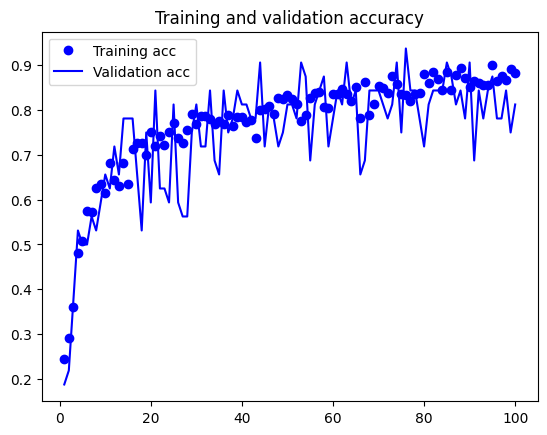

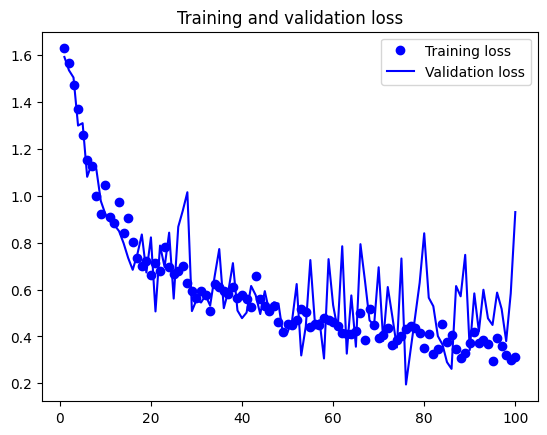

In [28]:
import matplotlib.pyplot as plt

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Applying Data Augmentation

In [42]:
train_aug_img_data_gen= ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range= 0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    fill_mode='nearest'
)

In [43]:
val_aug_img_data_gen= ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range= 0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    fill_mode='nearest'
)

In [44]:
train_aug_generator= train_aug_img_data_gen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    shuffle= True
)

Found 13474 images belonging to 5 classes.


In [46]:
val_aug_generator= val_aug_img_data_gen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    shuffle= True
)

Found 1497 images belonging to 5 classes.


In [57]:
# intializing model
model_do= models.Sequential()
model_do.add(layers.Conv2D(16, (3,3), activation='relu', input_shape= input_shape))
model_do.add(layers.MaxPooling2D((2,2)))
model_do.add(layers.Conv2D(32, (3,3), activation= 'relu'))
model_do.add(layers.MaxPooling2D((2,2)))
model_do.add(layers.Conv2D(64, (3,3), activation= 'relu'))
model_do.add(layers.MaxPooling2D((2,2)))
model_do.add(layers.Conv2D(128, (3,3), activation= 'relu'))
model_do.add(layers.MaxPooling2D((2,2)))
model_do.add(layers.Flatten())
model_do.add(layers.Dropout(0.5))
model_do.add(layers.Dense(128, activation='relu'))
model_do.add(layers.Dense(5, activation='softmax'))

In [63]:
#model_do.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_do.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
history_do= model_do.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs= 100,
    validation_data= val_generator,
    validation_steps= validation_steps
)

Epoch 1/100
13/13 [==============================] - 1s 89ms/step - loss: 0.4149 - accuracy: 0.8173 - val_loss: 0.6284 - val_accuracy: 0.7812
Epoch 2/100
13/13 [==============================] - 1s 80ms/step - loss: 0.7066 - accuracy: 0.7740 - val_loss: 0.5253 - val_accuracy: 0.8750
Epoch 3/100
13/13 [==============================] - 1s 71ms/step - loss: 1.1239 - accuracy: 0.6538 - val_loss: 0.3762 - val_accuracy: 0.8438
Epoch 4/100
13/13 [==============================] - 1s 74ms/step - loss: 0.5497 - accuracy: 0.7740 - val_loss: 0.4489 - val_accuracy: 0.8125
Epoch 5/100
13/13 [==============================] - 1s 70ms/step - loss: 0.3644 - accuracy: 0.8413 - val_loss: 0.3346 - val_accuracy: 0.8750
Epoch 6/100
13/13 [==============================] - 1s 77ms/step - loss: 0.4322 - accuracy: 0.8394 - val_loss: 0.3150 - val_accuracy: 0.8750
Epoch 7/100
13/13 [==============================] - 1s 76ms/step - loss: 0.3416 - accuracy: 0.8606 - val_loss: 0.3353 - val_accuracy: 0.8125
Epoch 

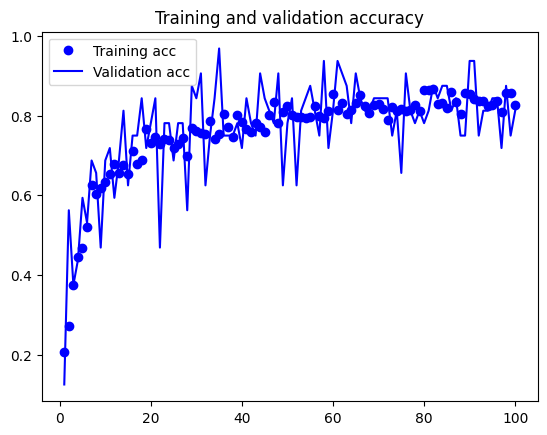

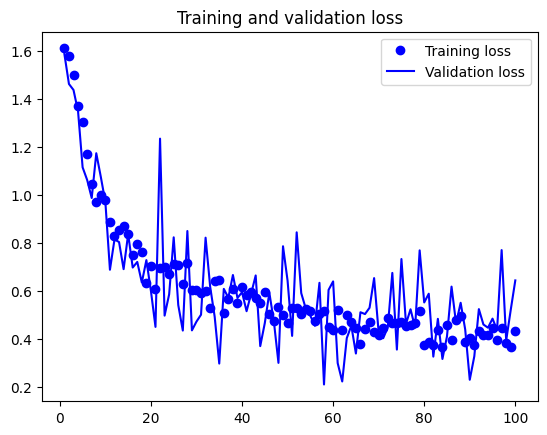

In [65]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
'